In [1]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [ ]:
# Neural Network Class

# Fully connected neural network with number of layers, neurons, input size, output size and activation function as parameters

class NeuralNetwork(nn.Module):
    def __init__(self, num_layers, num_neurons, input_size, output_size, activation_function):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.activation_function = activation_function

        # Input layer
        self.layers.append(nn.Linear(input_size, num_neurons))

        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(num_neurons, num_neurons))

        # Output layer
        self.layers.append(nn.Linear(num_neurons, output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
        x = self.layers[-1](x)
        return x

## define the activation functions: tanh() and sin()
def tanh(x):
    return torch.tanh(x)

def sin(x):
    return torch.sin(x)

# input size = 2, (x, t)


In [ ]:
# initial condition 
def ic_func(x):
    return np.cos(x[:, 0:1]) + 0.1 * np.sin(2 * x[:, 0:1])


In [ ]:
# boundary condition

## periodic boundary condition


In [ ]:
# Loss Function construction

## Residual loss function

def Residual_NN(x, u, t, u_t, u_xx):
    # Compute the residual of the PDE
    f = u_t + u_xx - np.sin(t) * np.cos(x)

    dy_dx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    return f

## Boundary loss function
def Boundary_NN(x, t, u):
    # Compute the boundary condition loss
    u_bc = torch.zeros_like(u)
    return u - u_bc

## Initial loss function
def Initial_NN(x, u):
    # Compute the initial condition loss
    u_ic = ic_func(x)
    return u - u_ic

## training loss function
def train_loss(data, model):
    x = x.requires_grad_()
    t = t.requires_grad_()
    u = u.requires_grad_()
    u_t = u_t.requires_grad_()
    u_xx = u_xx.requires_grad_()


    # Compute the total loss
    res_loss = Residual_NN(x, u, t, u_t, u_xx)
    bc_loss = Boundary_NN(x, t, u)
    ic_loss = Initial_NN(x, u)
    total_loss = res_loss + bc_loss + ic_loss
    return total_loss, res_loss,  ic_loss

import torch

# === Helper: Compute Derivatives for KS Equation ===
def compute_ks_derivatives(model, x, t):
    """
    Given a model that predicts u(x,t), compute:
      u, u_t, u_x, u_xx, u_xxx, and u_xxxx 
    using automatic differentiation.

    Inputs:
      model : the neural network model, taking (x, t)
      x, t  : tensors with requires_grad=True
  
    Returns:
      u, u_t, u_x, u_xx, u_xxx, u_xxxx
    """
    # Make sure x and t require gradients
    x = x.requires_grad_()
    t = t.requires_grad_()

    # Forward pass: predict u
    u = model(x, t)

    # First derivative with respect to time: u_t
    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    # First derivative with respect to space: u_x
    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    # Second derivative with respect to space: u_xx
    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    # Third derivative with respect to space: u_xxx
    u_xxx = torch.autograd.grad(
        u_xx, x,
        grad_outputs=torch.ones_like(u_xx),
        retain_graph=True,
        create_graph=True
    )[0]

    # Fourth derivative with respect to space: u_xxxx
    u_xxxx = torch.autograd.grad(
        u_xxx, x,
        grad_outputs=torch.ones_like(u_xxx),
        retain_graph=True,
        create_graph=True
    )[0]

    return u, u_t, u_x, u_xx, u_xxx, u_xxxx


# === Residual Loss Function for KS Equation ===
def residual_loss(model, x_f, t_f, nu):
    """
    Computes the residual loss for the KS equation:
       u_t + u*u_x + u_xx + nu*u_xxxx = 0
  
    Inputs:
      model: neural network that predicts u(x,t)
      x_f, t_f: collocation (interior) points where the PDE is enforced
      nu: parameter nu in the equation

    Returns:
      loss_res: a scalar tensor representing the Mean Squared Error (MSE)
                of the PDE residual.
    """
    # Compute u and necessary derivatives at collocation points:
    u, u_t, u_x, u_xx, _, u_xxxx = compute_ks_derivatives(model, x_f, t_f)
    
    # Compute the PDE residual f:
    # f = u_t + u*u_x + u_xx + nu*u_xxxx
    f = u_t + u * u_x + u_xx + nu * u_xxxx

    # Mean Squared Error of the residual (forcing f=0):
    loss_res = torch.mean(f**2)
    return loss_res


# === Boundary Loss Function for Periodic BC ===
def boundary_loss(model, x_left, t_left, x_right, t_right):
    """
    Computes the boundary loss for enforcing periodic boundary conditions.
    For a periodic domain [a, b] we enforce u(a,t) = u(b,t).

    Inputs:
      model: neural network that predicts u(x,t)
      x_left, t_left: points on the left boundary (e.g., x=a)
      x_right, t_right: corresponding points on the right boundary (e.g., x=b)

    Returns:
      loss_bc: the Mean Squared Error (MSE) between u(x_left,t_left) and u(x_right,t_right).
    """
    u_left = model(x_left, t_left)
    u_right = model(x_right, t_right)

    loss_bc = torch.mean((u_left - u_right)**2)
    return loss_bc


# === Initial Loss Function ===
def initial_loss(model, x_ic, t_ic, u_ic_target):
    """
    Computes the loss for the initial condition:
        u(x, t=0) = u_ic_target(x)

    Inputs:
      model: neural network that predicts u(x,t)
      x_ic, t_ic: the initial condition points (typically t_ic is zero)
      u_ic_target: true initial values obtained from your ic function

    Returns:
      loss_ic: Mean Squared Error (MSE) between network prediction and initial condition target.
    """
    u_ic_pred = model(x_ic, t_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic_target)**2)
    return loss_ic


# === Combined Training Loss Function ===
def train_loss(model, data, nu):
    """
    Computes the total loss by combining:
      - the residual loss (enforcing the KS PDE)
      - the boundary loss (enforcing periodic BC)
      - the initial loss (enforcing the IC)
      
    The `data` dictionary is assumed to have the following keys:
      - 'collocation': tuple (x_f, t_f)
      - 'boundary': tuple (x_left, t_left, x_right, t_right)
      - 'initial': tuple (x_ic, t_ic, u_ic_target)
      
    nu is the KS equation parameter.

    Returns:
      total_loss: the sum of the three loss terms.
      loss_r, loss_b, loss_i: individual loss components.
    """
    # Unpack the data dictionary
    x_f, t_f = data['collocation']
    x_left, t_left, x_right, t_right = data['boundary']
    x_ic, t_ic, u_ic_target = data['initial']

    # Compute each loss term:
    loss_r = residual_loss(model, x_f, t_f, nu)
    loss_b = boundary_loss(model, x_left, t_left, x_right, t_right)
    loss_i = initial_loss(model, x_ic, t_ic, u_ic_target)

    # Combine the losses (you can also weight these if needed)
    total_loss = loss_r + loss_b + loss_i
    return total_loss, loss_r, loss_b, loss_i


In [ ]:
# training process
epochs = 5000

loss_history = []
ode_loss_history = []
initial_loss_history = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = NeuralNetwork(num_layers=4, num_neurons=50, input_size=1, output_size=1, activation_function=tanh)
print(model)

x_train = torch.linspace(-2, 2, 100).view(-1, 1)  # Training points

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, ode_loss, initial_loss = train_loss(model, x_train)
    total_loss.backward()
    optimizer.step()

    
    loss_history.append(total_loss.item())
    ode_loss_history.append(ode_loss.item())
    initial_loss_history.append(initial_loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")




In [ ]:
import numpy as np
import torch

def load_training_data(params):
    """
    Load and process training data for the KS equation.
    
    The training data is expected to be stored in a .npy file with shape:
      (num_time_points, num_space_points)
    which represents the solution u(x,t) on a grid. This function creates
    observation points (x, t) corresponding to the values in the data.
    
    Parameters:
      params (dict): A dictionary containing:
          'T'  : Total time domain length (we use first T/2 for training).
          'L'  : Spatial domain length.
          'N'  : Expected number of spatial points.
    
    Returns:
      data_dict (dict): A dictionary with keys:
            'x_data'      : Tensor of x coordinates (shape [N_obs, 1]).
            't_data'      : Tensor of t coordinates (shape [N_obs, 1]).
            'u_data_target': Tensor of u values (observations, shape [N_obs, 1]).
    """
    # Load the training data
    training_data = np.load('../../../data/ks_training.npy')
    
    # Get dimensions from training data
    n_time, n_space = training_data.shape
    
    # Check for consistency with parameters (if provided)
    if 'N' in params and params['N'] != n_space:
        print("Warning: params['N'] (%d) does not match the number of spatial points in the training data (%d). Using data shape." 
              % (params['N'], n_space))
    
    # Create the time axis for the first half of the time domain
    t = np.linspace(0, params['T'] / 2, n_time)
    # Create the spatial axis from 0 to L
    x = np.linspace(0, params['L'], n_space)
    
    # Create an observation grid via meshgrid.
    # X holds spatial coordinates and T_grid holds time coordinates.
    X, T_grid = np.meshgrid(x, t)
    
    # Flatten the grid to generate observation points.
    # Each observation point has the structure [x, t].
    X_train = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
    
    # Flatten the training data to get corresponding u values.
    y_train = training_data.flatten()[:, None]
    
    # Convert the data to PyTorch tensors.
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    # Split the input into x_data and t_data.
    x_data = X_train[:, 0:1]
    t_data = X_train[:, 1:2]
    
    # Pack the tensors in a structured dictionary.
    data_dict = {
        'x_data': x_data,
        't_data': t_data,
        'u_data_target': y_train
    }
    
    return data_dict


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ===================================================
# 1. Activation Functions
# ===================================================

def tanh(x):
    return torch.tanh(x)

def sin(x):
    return torch.sin(x)

# ===================================================
# 2. Neural Network Definition for (x, t) Inputs
# ===================================================

class NeuralNetwork(nn.Module):
    def __init__(self, num_layers, num_neurons, input_size, output_size, activation_function):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.activation_function = activation_function

        # Input layer (input_size should be 2 for x and t)
        self.layers.append(nn.Linear(input_size, num_neurons))
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(num_neurons, num_neurons))
        # Output layer
        self.layers.append(nn.Linear(num_neurons, output_size))

    def forward(self, x, t):
        # Concatenate spatial and temporal inputs along the feature dimension.
        inp = torch.cat((x, t), dim=1)
        for layer in self.layers[:-1]:
            inp = self.activation_function(layer(inp))
        output = self.layers[-1](inp)
        return output

# ===================================================
# 3. Helper: Compute Derivatives for KS Equation
# ===================================================

def compute_ks_derivatives(model, x, t):
    """
    Computes u, u_t, u_x, u_xx, u_xxx, and u_xxxx using automatic differentiation.
    """
    x = x.requires_grad_()
    t = t.requires_grad_()

    u = model(x, t)

    # Time derivative u_t = du/dt
    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    # First spatial derivative u_x = du/dx
    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    # Second derivative u_xx = d²u/dx²
    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    # Third derivative u_xxx = d³u/dx³
    u_xxx = torch.autograd.grad(
        u_xx, x,
        grad_outputs=torch.ones_like(u_xx),
        retain_graph=True,
        create_graph=True
    )[0]

    # Fourth derivative u_xxxx = d⁴u/dx⁴
    u_xxxx = torch.autograd.grad(
        u_xxx, x,
        grad_outputs=torch.ones_like(u_xxx),
        retain_graph=True,
        create_graph=True
    )[0]

    return u, u_t, u_x, u_xx, u_xxx, u_xxxx

# ===================================================
# 4. Loss Functions for the KS Equation
# ===================================================

def residual_loss(model, x_f, t_f, nu):
    """
    Enforce the KS PDE:
      u_t + u*u_x + u_xx + nu*u_xxxx = 0.
    """
    u, u_t, u_x, u_xx, _, u_xxxx = compute_ks_derivatives(model, x_f, t_f)
    f = u_t + u * u_x + u_xx + nu * u_xxxx
    loss_r = torch.mean(f**2)
    return loss_r

def boundary_loss(model, x_left, t_left, x_right, t_right):
    """
    Enforce periodic boundary conditions:
      u(-2, t) = u(2, t).
    """
    u_left = model(x_left, t_left)
    u_right = model(x_right, t_right)
    loss_b = torch.mean((u_left - u_right)**2)
    return loss_b

def initial_loss(model, x_ic, t_ic, u_ic_target):
    """
    Enforce the initial condition:
      u(x, 0) = u_ic_target(x).
    """
    u_ic_pred = model(x_ic, t_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic_target)**2)
    return loss_ic

def data_loss(model, x_data, t_data, u_data_target):
    """
    Data loss: mean squared error between the network prediction and observed data.
    """
    u_pred = model(x_data, t_data)
    loss_d = torch.mean((u_pred - u_data_target)**2)
    return loss_d

def train_loss(model, data, nu):
    """
    Total loss is the sum of the residual, boundary, initial, and data losses.
    
    The provided data dictionary should have the following keys:
      - 'collocation': tuple (x_f, t_f)
      - 'boundary': tuple (x_left, t_left, x_right, t_right)
      - 'initial': tuple (x_ic, t_ic, u_ic_target)
      - 'data': tuple (x_data, t_data, u_data_target)
    """
    x_f, t_f = data['collocation']
    x_left, t_left, x_right, t_right = data['boundary']
    x_ic, t_ic, u_ic_target = data['initial']
    x_data, t_data, u_data_target = data['data']

    loss_r = residual_loss(model, x_f, t_f, nu)
    loss_b = boundary_loss(model, x_left, t_left, x_right, t_right)
    loss_ic = initial_loss(model, x_ic, t_ic, u_ic_target)
    loss_d = data_loss(model, x_data, t_data, u_data_target)

    total_loss = loss_r + loss_b + loss_ic + loss_d
    return total_loss, loss_r, loss_b, loss_ic, loss_d

# ===================================================
# 5. Data Loading Functions
# ===================================================

def load_training_data(params):
    """
    Load and process training data for the KS equation.
    
    The training data is assumed to be stored in a .npy file with shape:
      (num_time_points, num_space_points)
    which represents u(x, t) on a grid. This function uses the first half
    of the time domain and returns the data in a structured dictionary.
    
    Parameters:
      params (dict): Must include:
          'T'  : Total time domain length.
          'L'  : Spatial domain length.
          'N'  : Expected number of spatial points.
          'data_path': Path to the .npy file.
    
    Returns:
      data_dict (dict): Dictionary with keys:
            'x_data'       : Tensor of x coordinates (shape [N_obs, 1]).
            't_data'       : Tensor of t coordinates (shape [N_obs, 1]).
            'u_data_target': Tensor of u observations (shape [N_obs, 1]).
    """
    training_data = np.load(params['data_path'])
    n_time, n_space = training_data.shape

    if 'N' in params and params['N'] != n_space:
        print("Warning: params['N'] (%d) does not match the number of spatial points in the training data (%d). Using data shape."
              % (params['N'], n_space))
    
    # Use the first half of the time domain
    t = np.linspace(0, params['T'] / 2, n_time)
    x = np.linspace(0, params['L'], n_space)
    
    # Create observation grid via meshgrid.
    X, T_grid = np.meshgrid(x, t)
    X_train = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
    y_train = training_data.flatten()[:, None]
    
    # Convert to PyTorch tensors.
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    # Split input into spatial and temporal components.
    x_data = X_train[:, 0:1]
    t_data = X_train[:, 1:2]

    data_dict = {
        'x_data': x_data,
        't_data': t_data,
        'u_data_target': y_train
    }
    
    return data_dict

def load_training_data(params):
    """Load and process training data"""
    training_data = np.load('../../../data/ks_training.npy')
    t = np.linspace(0, params['T']/2, training_data.shape[0])  # First half of time domain
    x = np.linspace(0, params['L'], params['N'])
    
    # Create observation points
    X, T = np.meshgrid(x, t)
    X_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    y_train = training_data.flatten()[:, None]
    
    return X_train, y_train

# ===================================================
# 6. Define Initial Condition Function
# ===================================================

def ic_func(x):
    # For example, initial condition u(x,0) = cos(x)
    return torch.cos(x)

# ===================================================
# 7. Generate Other Training Data Components
# ===================================================

# Domain settings
x_min, x_max = -2.0, 2.0
t_min, t_max = 0.0, 1.0

# Collocation points for the PDE residual
N_f = 1000
x_f = torch.linspace(x_min, x_max, N_f).view(-1, 1)
t_f = torch.rand(N_f, 1) * (t_max - t_min) + t_min

# Boundary points for enforcing periodic conditions: u(x_min, t)=u(x_max, t)
N_b = 100
x_left = x_min * torch.ones(N_b, 1)
x_right = x_max * torch.ones(N_b, 1)
t_b = torch.rand(N_b, 1) * (t_max - t_min) + t_min
t_left = t_b
t_right = t_b

# Initial condition points (t = 0)
N_ic = 100
x_ic = torch.linspace(x_min, x_max, N_ic).view(-1, 1)
t_ic = torch.zeros(N_ic, 1)
u_ic_target = ic_func(x_ic)

# Load observed training data from file
params = {'T': 1.0, 'L': 4.0, 'N': 100, 'data_path': 'D:\ML4DE_Challenge\data\ks_training.npy'}
data_obs = load_training_data(params)
# Use keys 'x_data', 't_data', 'u_data_target' from the loaded data dictionary.

# Bundle all components into a single data dictionary for loss evaluation.
data = {
    'collocation': (x_f, t_f),
    'boundary': (x_left, t_left, x_right, t_right),
    'initial': (x_ic, t_ic, u_ic_target),
    'data': (data_obs['x_data'], data_obs['t_data'], data_obs['u_data_target'])
}

# ===================================================
# 8. Construct the PINN Model and Trainable Parameter nu
# ===================================================

# Model: input dimension is 2 (x and t), output dimension is 1.
model = NeuralNetwork(num_layers=4, num_neurons=50, input_size=2, output_size=1, activation_function=tanh)
print(model)

# Unknown parameter nu defined as a trainable parameter.
nu = torch.nn.Parameter(torch.tensor([0.01], dtype=torch.float32))

# ===================================================
# 9. Training Process
# ===================================================

optimizer = optim.Adam(list(model.parameters()) + [nu], lr=0.001)
epochs = 5000

loss_history = []
residual_loss_history = []
boundary_loss_history = []
initial_loss_history = []
data_loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, loss_r, loss_b, loss_ic, loss_d = train_loss(model, data, nu)
    total_loss.backward()
    optimizer.step()
    
    loss_history.append(total_loss.item())
    residual_loss_history.append(loss_r.item())
    boundary_loss_history.append(loss_b.item())
    initial_loss_history.append(loss_ic.item())
    data_loss_history.append(loss_d.item())
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Total Loss={total_loss.item():.6f}, Residual Loss={loss_r.item():.6f}, "
              f"Boundary Loss={loss_b.item():.6f}, Initial Loss={loss_ic.item():.6f}, "
              f"Data Loss={loss_d.item():.6f}, nu={nu.item():.6f}")

print("Training complete. Final nu =", nu.item())


<>:255: SyntaxWarning: invalid escape sequence '\M'
<>:255: SyntaxWarning: invalid escape sequence '\M'
C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_39608\3061396985.py:255: SyntaxWarning: invalid escape sequence '\M'
  params = {'T': 1.0, 'L': 4.0, 'N': 100, 'data_path': 'D:\ML4DE_Challenge\data\ks_training.npy'}


NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
Epoch 0: Total Loss=4.869152, Residual Loss=0.000377, Boundary Loss=0.004793, Initial Loss=0.390681, Data Loss=4.473301, nu=0.011000
Epoch 1000: Total Loss=4.227118, Residual Loss=0.002776, Boundary Loss=0.002026, Initial Loss=0.028095, Data Loss=4.194222, nu=0.482738
Epoch 2000: Total Loss=4.217396, Residual Loss=0.001154, Boundary Loss=0.001567, Initial Loss=0.021693, Data Loss=4.192981, nu=0.574810
Epoch 3000: Total Loss=4.199983, Residual Loss=0.003041, Boundary Loss=0.001345, Initial Loss=0.016084, Data Loss=4.179513, nu=0.886773
Epoch 4000: Total Loss=4.150917, Residual Loss=0.004372, Boundary Loss=0.002403, Initial Loss=0.009066, Data Loss=4.135076, nu=1.490006
Training complete. Final nu = 1.6651071310043335


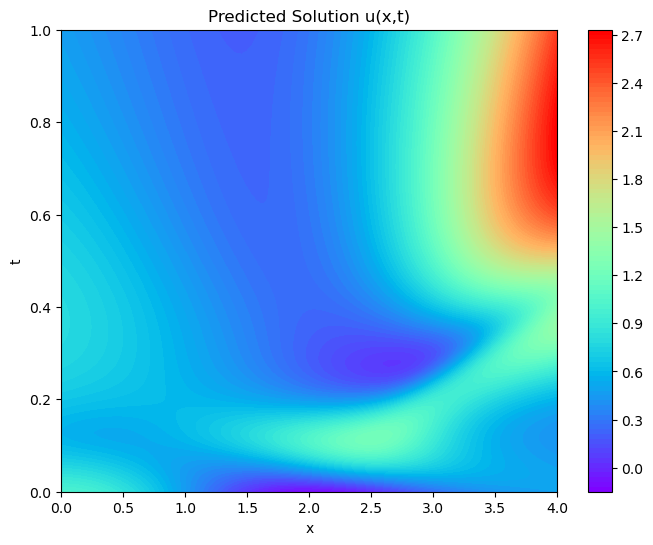

In [17]:
# evaluation
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_solution(x, t, u):
    """
    Plot the solution u(x,t) as a contourf plot.
    
    Parameters:
      x : 1D numpy array for the spatial grid
      t : 1D numpy array for the temporal grid
      u : 2D numpy array with shape (len(t), len(x)) representing u(x,t)
    """
    X, T = np.meshgrid(x, t)
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, T, u, 100, cmap='rainbow')
    plt.colorbar(cp)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Solution u(x,t)')
    plt.show()

# --- Generate prediction points ---
# Assume params is a dictionary with keys 'T', 'L', and 'N'.
params = {'T': 1.0, 'L': 4.0, 'N': 100}

# Create a temporal grid with 201 points and a spatial grid with params['N'] points.
t_pred = np.linspace(0, params['T'], 201)  
x_pred = np.linspace(0, params['L'], params['N'])
X_pred, T_pred = np.meshgrid(x_pred, t_pred)

# Stack the grids into a 2D array of (x,t) pairs.
X_star = np.hstack((X_pred.flatten()[:, None], T_pred.flatten()[:, None]))

# --- Get the model prediction ---
# Set the model to evaluation mode and disable gradient computation.
model.eval()  
with torch.no_grad():
    # Convert X_star to a torch tensor.
    X_star_tensor = torch.tensor(X_star, dtype=torch.float32)
    # Separate the input into x and t components.
    x_tensor = X_star_tensor[:, 0:1]
    t_tensor = X_star_tensor[:, 1:2]
    
    # Pass them into the model.
    u_pred_tensor = model(x_tensor, t_tensor)
    # Convert the predictions back to a numpy array.
    u_pred = u_pred_tensor.detach().cpu().numpy()

# Reshape prediction to a grid with shape (len(t_pred), len(x_pred))
u_pred = u_pred.reshape(len(t_pred), len(x_pred))

# --- Plot the prediction ---
plot_solution(x_pred, t_pred, u_pred)

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Data Loading Functions
# ------------------------------------------------------------------
def load_training_data(params):
    """Load and process training data from a file.
    
    (This is your original function; here we use it as a reference.)
    """
    training_data = np.load('../../../data/ks_training.npy')
    t = np.linspace(0, params['T']/2, training_data.shape[0])  # First half of time domain
    x = np.linspace(0, params['L'], params['N'])
    
    # Create observation points (flattened grid)
    X, T_grid = np.meshgrid(x, t)
    X_train = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
    y_train = training_data.flatten()[:, None]
    
    return X_train, y_train

def load_ground_truth_data(params):
    """Load and process ground truth data for evaluation.
    
    This function is essentially the same as load_training_data, but
    the path is changed to load the ground truth data.
    
    Parameters:
      params (dict): Must include:
          'T'  : Total time domain length.
          'L'  : Spatial domain length.
          'N'  : Expected number of spatial points.
          'ground_truth_path': Path to the ground truth .npy file.
    
    Returns:
      X_truth (np.ndarray): Flattened (x,t) observation points.
      y_truth (np.ndarray): Ground truth u values (flattened).
    """
    ground_truth_data = np.load(params['ground_truth_path'])
    n_time, n_space = ground_truth_data.shape
    t = np.linspace(0, params['T']/2, n_time)  # use first half of time
    x = np.linspace(0, params['L'], params['N'])
    
    X, T_grid = np.meshgrid(x, t)
    X_truth = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
    y_truth = ground_truth_data.flatten()[:, None]
    
    return X_truth, y_truth

# ------------------------------------------------------------------
# 2. Plotting and Evaluation Functions
# ------------------------------------------------------------------
def plot_comparison(x, t, u_truth, u_pred):
    """
    Plot the ground truth and predicted solutions side-by-side.
    
    Parameters:
      x       : 1D numpy array of spatial grid points.
      t       : 1D numpy array of temporal grid points.
      u_truth : 2D array of ground truth solution u(x,t) with shape (len(t), len(x)).
      u_pred  : 2D array of predicted solution with shape (len(t), len(x)).
    """
    plt.figure(figsize=(12, 5))
    
    # Ground truth plot
    plt.subplot(1, 2, 1)
    cp1 = plt.contourf(x, t, u_truth, 100, cmap='viridis')
    plt.colorbar(cp1)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Ground Truth Solution')
    
    # Predicted solution plot
    plt.subplot(1, 2, 2)
    cp2 = plt.contourf(x, t, u_pred, 100, cmap='viridis')
    plt.colorbar(cp2)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Solution')
    
    plt.tight_layout()
    plt.show()

def evaluate_prediction(u_truth, u_pred):
    """
    Evaluate the prediction using the relative L2 norm.
    
    Parameters:
      u_truth: Ground truth solution as a numpy array.
      u_pred : Predicted solution as a numpy array.
      
    Returns:
      rel_error: The relative L2 error between prediction and ground truth.
    """
    error_norm = np.linalg.norm(u_truth - u_pred)
    truth_norm = np.linalg.norm(u_truth)
    rel_error = error_norm / truth_norm
    return rel_error

# ------------------------------------------------------------------
# 3. MAIN SCRIPT: Load Data, Compare, and Evaluate
# ------------------------------------------------------------------
# Define parameters. Adjust these as needed.
params = {
    'T': 1.0,                  # Total time length
    'L': 4.0,                  # Spatial domain length
    'N': 100,                  # Expected number of spatial points
    'ground_truth_path': 'D:\ML4DE_Challenge\data\ks_truth.npy'  # Change to your ground truth file path
}

# --- Load Ground Truth ---
X_truth, y_truth, n_time, n_space = load_ground_truth_data(params)
# Reshape the flat ground truth data back to its 2D grid shape.
u_truth = y_truth.reshape(n_time, n_space)

# --- Generate Prediction Grid ---
# Use the same number of time and space points as in the ground truth.
t_pred = np.linspace(0, params['T']/2, n_time)
x_pred = np.linspace(0, params['L'], n_space)
# Create a meshgrid for the evaluation points.
X_mesh, T_mesh = np.meshgrid(x_pred, t_pred)
# Build a 2-column array with each row representing an (x,t) pair.
X_star = np.hstack((X_mesh.flatten()[:, None], T_mesh.flatten()[:, None]))

# --- Generate Predictions from the Trained Model ---
# (Assumes that 'model' is the trained PINN model defined using PyTorch.)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Convert the grid to a torch tensor.
    X_star_tensor = torch.tensor(X_star, dtype=torch.float32)
    # Split into x and t components.
    x_star_tensor = X_star_tensor[:, 0:1]
    t_star_tensor = X_star_tensor[:, 1:2]
    # Evaluate the model.
    u_pred_tensor = model(x_star_tensor, t_star_tensor)
    # Convert to a numpy array.
    u_pred = u_pred_tensor.detach().cpu().numpy()

# Reshape the predictions to a 2D grid.
u_pred = u_pred.reshape(n_time, n_space)

# --- Plot and Compare ---
plot_comparison(x_pred, t_pred, u_truth, u_pred)

# --- Evaluate the Prediction Error ---
rel_error = evaluate_prediction(u_truth, u_pred)
print("Relative L2 error between prediction and ground truth:", rel_error)


<>:109: SyntaxWarning: invalid escape sequence '\M'
<>:109: SyntaxWarning: invalid escape sequence '\M'
C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_39608\573093603.py:109: SyntaxWarning: invalid escape sequence '\M'
  'ground_truth_path': 'D:\ML4DE_Challenge\data\ks_truth.npy'  # Change to your ground truth file path
C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_39608\573093603.py:109: SyntaxWarning: invalid escape sequence '\M'
  'ground_truth_path': 'D:\ML4DE_Challenge\data\ks_truth.npy'  # Change to your ground truth file path


ValueError: not enough values to unpack (expected 4, got 2)

<>:114: SyntaxWarning: invalid escape sequence '\M'
<>:114: SyntaxWarning: invalid escape sequence '\M'
C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_39608\1077059078.py:114: SyntaxWarning: invalid escape sequence '\M'
  'ground_truth_path': 'D:\ML4DE_Challenge\data\ks_truth.npy'  # Change to your ground truth file path


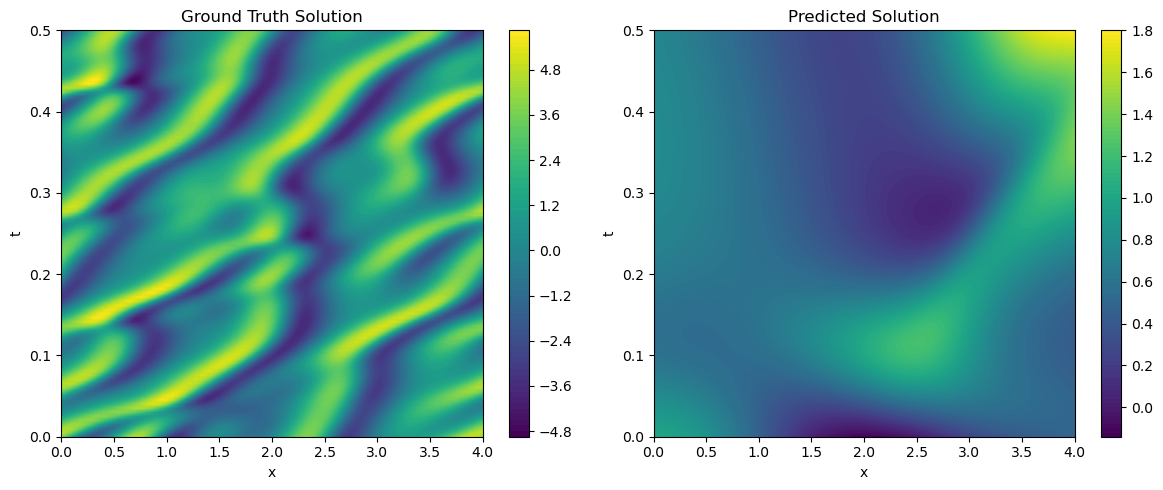

Relative L2 error between prediction and ground truth: 0.9719135020883155


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Data Loading Functions
# ------------------------------------------------------------------
def load_training_data(params):
    """Load and process training data.
    
    Expected shape: (n_time, n_space), using the first half of the time domain.
    """
    training_data = np.load('../../../data/ks_training.npy')
    n_time, n_space = training_data.shape
    t = np.linspace(0, params['T']/2, n_time)
    x = np.linspace(0, params['L'], params['N'])
    
    # Create observation grid using meshgrid.
    X, T_grid = np.meshgrid(x, t)
    X_train = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
    y_train = training_data.flatten()[:, None]
    
    return X_train, y_train

def load_ground_truth_data(params):
    """
    Load and process ground truth data.
    
    The ground truth file is assumed to have shape (n_time, n_space).
    This function uses the first half of the time domain.
    
    Parameters:
      params (dict): Must include:
          'T'              : Total time domain length.
          'L'              : Spatial domain length.
          'ground_truth_path': Path to the ground truth .npy file.
    
    Returns:
      X_truth (np.ndarray): Flattened (x,t) observation points (not used further here).
      y_truth (np.ndarray): Ground truth u values (flattened).
      n_time (int): Number of time points in the ground truth data.
      n_space (int): Number of spatial points in the ground truth data.
    """
    ground_truth_data = np.load(params['ground_truth_path'])
    n_time, n_space = ground_truth_data.shape
    t = np.linspace(0, params['T']/2, n_time)  # Use first half of time domain
    x = np.linspace(0, params['L'], n_space)
    
    # Create the observation grid (flattened)
    X, T_grid = np.meshgrid(x, t)
    X_truth = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
    y_truth = ground_truth_data.flatten()[:, None]
    
    return X_truth, y_truth, n_time, n_space

# ------------------------------------------------------------------
# 2. Plotting and Evaluation Functions
# ------------------------------------------------------------------
def plot_comparison(x, t, u_truth, u_pred):
    """
    Plot the ground truth and predicted solutions side-by-side.
    
    Parameters:
      x       : 1D numpy array of spatial grid points.
      t       : 1D numpy array of temporal grid points.
      u_truth : 2D array with shape (len(t), len(x)) for the ground truth.
      u_pred  : 2D array with shape (len(t), len(x)) for the prediction.
    """
    plt.figure(figsize=(12, 5))
    
    # Ground truth plot
    plt.subplot(1, 2, 1)
    cp1 = plt.contourf(x, t, u_truth, 100, cmap='viridis')
    plt.colorbar(cp1)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Ground Truth Solution')
    
    # Predicted solution plot
    plt.subplot(1, 2, 2)
    cp2 = plt.contourf(x, t, u_pred, 100, cmap='viridis')
    plt.colorbar(cp2)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Solution')
    
    plt.tight_layout()
    plt.show()

def evaluate_prediction(u_truth, u_pred):
    """
    Evaluate the prediction using the relative L2 norm.
    
    Parameters:
      u_truth: 2D array of ground truth solution.
      u_pred : 2D array of predicted solution.
      
    Returns:
      rel_error: The relative L2 error between prediction and ground truth.
    """
    error_norm = np.linalg.norm(u_truth - u_pred)
    truth_norm = np.linalg.norm(u_truth)
    rel_error = error_norm / truth_norm
    return rel_error

# ------------------------------------------------------------------
# 3. MAIN SCRIPT: Load Data, Compare, and Evaluate
# ------------------------------------------------------------------
# Define parameters. (Adjust these values and paths as needed.)

params = {
    'T': 1.0,                  # Total time length
    'L': 4.0,                  # Spatial domain length
    'N': 100,                  # Expected number of spatial points
    'ground_truth_path': 'D:\ML4DE_Challenge\data\ks_truth.npy'  # Change to your ground truth file path
}

# --- Load Ground Truth ---
X_truth, y_truth, n_time, n_space = load_ground_truth_data(params)
# Reshape the flat ground truth data back to its 2D grid shape.
u_truth = y_truth.reshape(n_time, n_space)

# --- Generate Prediction Grid ---
# Use the same number of time and space points as in the ground truth.
t_pred = np.linspace(0, params['T']/2, n_time)
x_pred = np.linspace(0, params['L'], n_space)
# Create a meshgrid for the evaluation points.
X_mesh, T_mesh = np.meshgrid(x_pred, t_pred)
# Build a 2-column array with each row representing an (x,t) pair.
X_star = np.hstack((X_mesh.flatten()[:, None], T_mesh.flatten()[:, None]))

# --- Generate Predictions from the Trained Model ---
# (Assumes that 'model' is the trained PINN model defined using PyTorch.)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Convert the grid to a torch tensor.
    X_star_tensor = torch.tensor(X_star, dtype=torch.float32)
    # Split into x and t components.
    x_star_tensor = X_star_tensor[:, 0:1]
    t_star_tensor = X_star_tensor[:, 1:2]
    # Evaluate the model.
    u_pred_tensor = model(x_star_tensor, t_star_tensor)
    # Convert to a numpy array.
    u_pred = u_pred_tensor.detach().cpu().numpy()

# Reshape the predictions to a 2D grid.
u_pred = u_pred.reshape(n_time, n_space)

# --- Plot and Compare ---
plot_comparison(x_pred, t_pred, u_truth, u_pred)

# --- Evaluate the Prediction Error ---
rel_error = evaluate_prediction(u_truth, u_pred)
print("Relative L2 error between prediction and ground truth:", rel_error)